In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score

In [2]:
G = nx.read_gml("football.gml")

n, m = G.number_of_nodes(), G.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")

Nodes: 115, Edges: 613


Graph summary: |V|=115, |E|=613


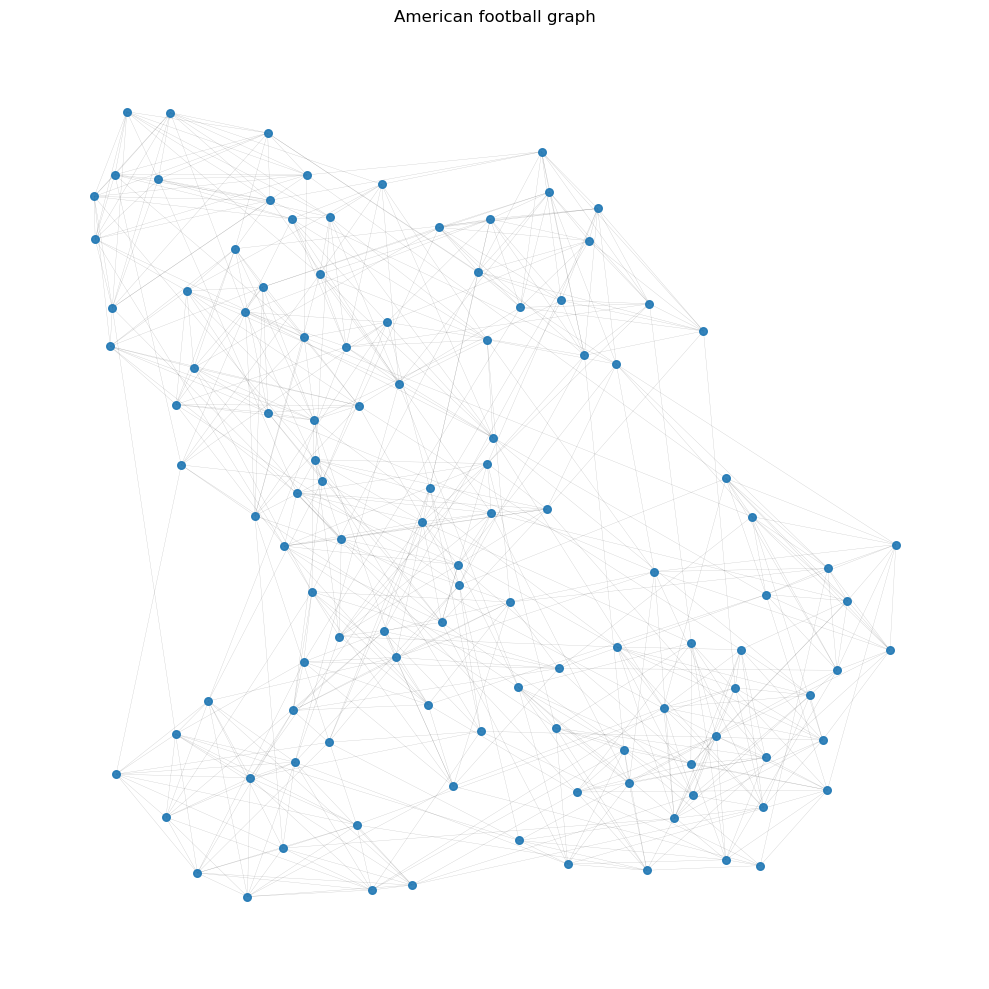

/tmp/ipykernel_95439/3847296293.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# If G not yet loaded (american football), uncomment one of the following:
# G = nx.read_gml('football.gml')  # adjust path; may need label='id'
# G = nx.read_gml('../Data sets/Community Detection/football.gml', label='id')

print(f"Graph summary: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

# Fast layout for big graphs
pos = nx.spring_layout(G, seed=0)

# On-screen quick view (no labels)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=30, node_color='#1f77b4', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=0.2, edge_color='black', alpha=0.25)
plt.axis('off')
plt.title("American football graph")
plt.tight_layout()
plt.show()

# Save a high-res image
plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_size=30, width=0.2, edge_color='black', with_labels=False, alpha=0.9)
plt.axis('off')
plt.tight_layout()
plt.savefig('football_graph.png', dpi=300, bbox_inches='tight')
plt.close()

In [4]:
def laplacian_matrix(G):
    return nx.laplacian_matrix(G)

def laplacian_sym(G):
    return nx.normalized_laplacian_matrix(G)  # L_sym = D^{-1/2} L D^{-1/2}

def laplacian_rw(G):
    A = nx.adjacency_matrix(G)
    deg = np.array(A.sum(axis=1)).flatten()
    D_inv = np.diag(1.0 / np.maximum(deg, 1))
    L = nx.laplacian_matrix(G).toarray()
    return D_inv @ L  # L_rw = D^{-1} L

def spectral_clustering(L, m, row_normalize=False):
    vals, vecs = eigsh(L, k=m, which="SM")
    X = np.real(vecs)
    if row_normalize:
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        norms[norms == 0] = 1
        X = X / norms
    labels = KMeans(n_clusters=m).fit_predict(X)
    return labels, vals, X

def align_labels(ref_labels, target_labels):
    cm = confusion_matrix(ref_labels, target_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize matching
    mapping = dict(zip(col_ind, row_ind))
    aligned = np.array([mapping[l] for l in target_labels])
    return aligned

def plot_spectrum(ax, vals, title):
    vals_sorted = sorted(vals)
    ax.plot(range(1, len(vals_sorted)+1), vals_sorted, "o-")
    ax.set_title(title + " - spectrum")
    ax.set_xlabel("Index"); ax.set_ylabel("Eigenvalue")
    ax.grid(True, ls=":")

def plot_embedding(ax, X, labels, title):
    X2 = X[:, :2]
    ax.scatter(X2[:,0], X2[:,1], c=labels, cmap="tab20", s=20)
    ax.set_title(title + " - embedding")
    ax.set_xlabel("eigvec 1"); ax.set_ylabel("eigvec 2")

def plot_graph(ax, G, pos, labels, title):
    nx.draw_networkx_nodes(G, pos, node_color=labels, cmap="tab20", node_size=40, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, ax=ax)
    ax.set_title(title + " - graph"); ax.axis("off")

<class 'networkx.utils.decorators.argmap'> compilation 17:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 21:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/tmp/ipykernel_95439/1670511745.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


ARI (Unnormalized): 0.8966500097910517
ARI (Symmetric): 0.9063341575567592
ARI (Random-walk): 0.8966500097910517


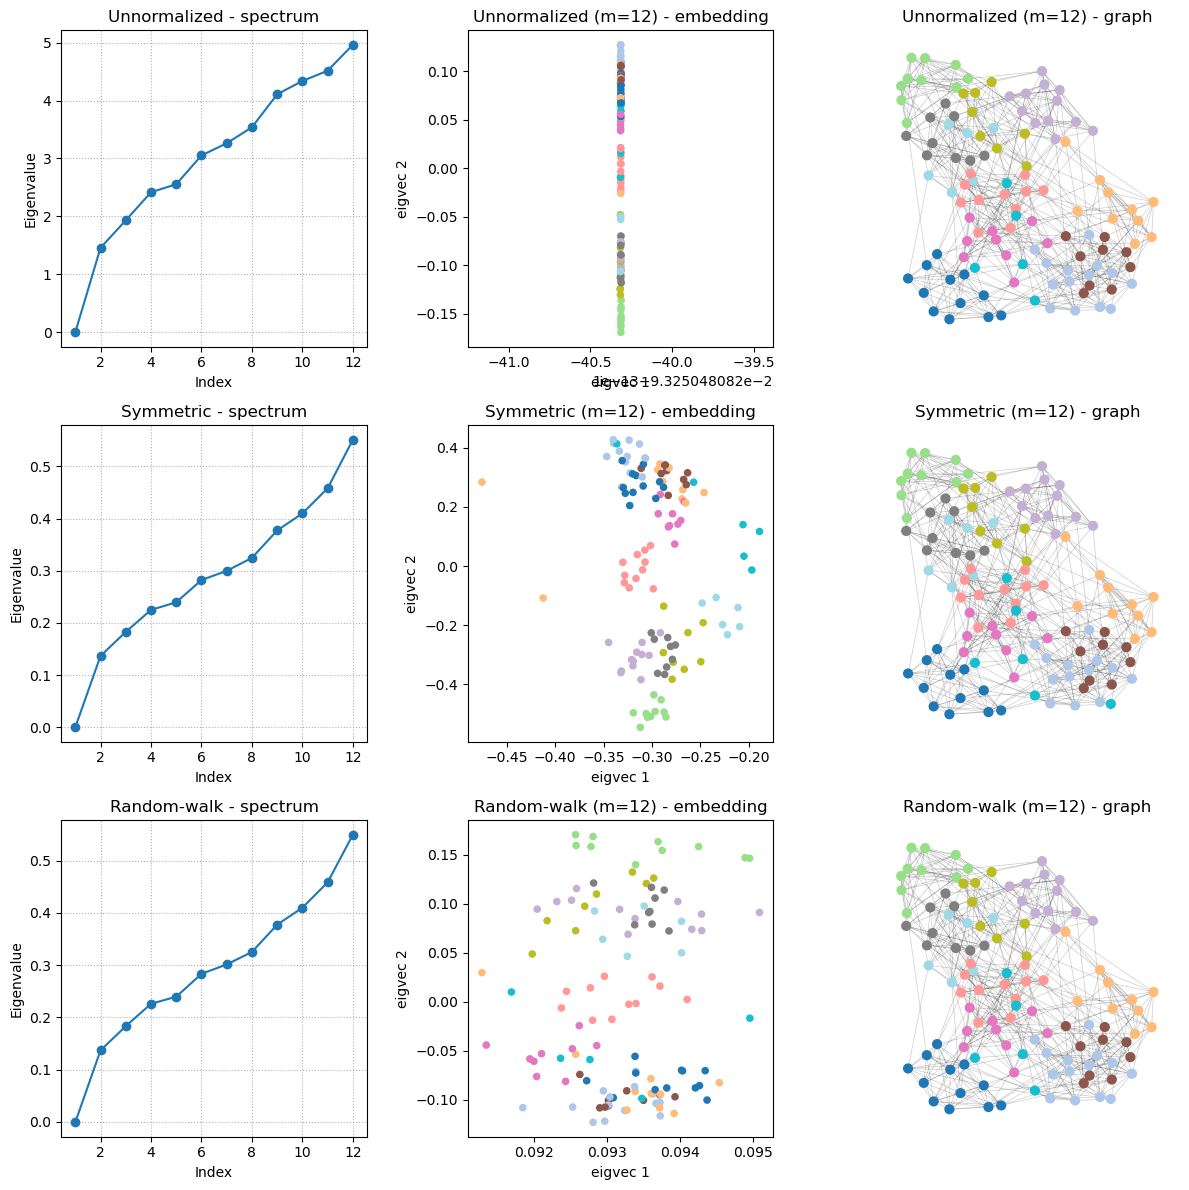

In [25]:
m = 12 # number of conferences
true_labels = np.array([G.nodes[v]['value'] for v in G.nodes()]) # ground truth

L = laplacian_matrix(G).astype(float)

L_sym = laplacian_sym(G)
L_rw = laplacian_rw(G)

labels, vals, X = spectral_clustering(L, m, row_normalize=False)
labels_sym, vals_sym, X_sym = spectral_clustering(L_sym, m, row_normalize=True)
labels_rw, vals_rw, X_rw = spectral_clustering(L_rw, m, row_normalize=False)

# Align labels for better comparison
labels_sym = align_labels(labels, labels_sym)
labels_rw  = align_labels(labels, labels_rw)

pos = nx.spring_layout(G, seed=0)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

plot_spectrum(axes[0,0], vals, "Unnormalized")
plot_embedding(axes[0,1], X, labels, f"Unnormalized (m={m})")
plot_graph(axes[0,2], G, pos, labels, f"Unnormalized (m={m})")
print("ARI (Unnormalized):", adjusted_rand_score(true_labels, labels))

plot_spectrum(axes[1,0], vals_sym, "Symmetric")
plot_embedding(axes[1,1], X_sym, labels_sym, f"Symmetric (m={m})")
plot_graph(axes[1,2], G, pos, labels_sym, f"Symmetric (m={m})")
print("ARI (Symmetric):", adjusted_rand_score(true_labels, labels_sym))

plot_spectrum(axes[2,0], vals_rw, "Random-walk")
plot_embedding(axes[2,1], X_rw, labels_rw, f"Random-walk (m={m})")
plot_graph(axes[2,2], G, pos, labels_rw, f"Random-walk (m={m})")
print("ARI (Random-walk):", adjusted_rand_score(true_labels, labels_rw))

plt.tight_layout()
plt.show()